Length in time (s):  3.0


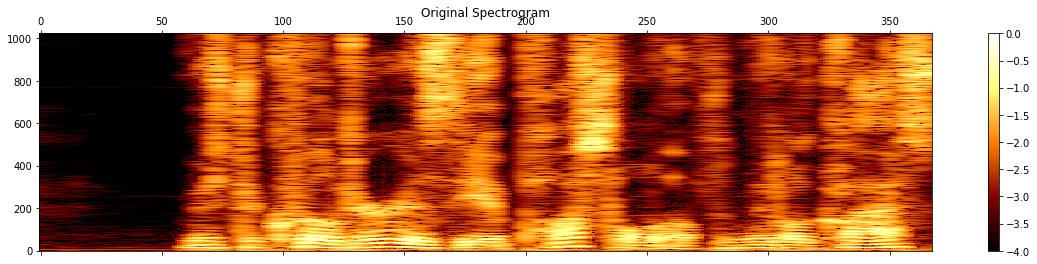

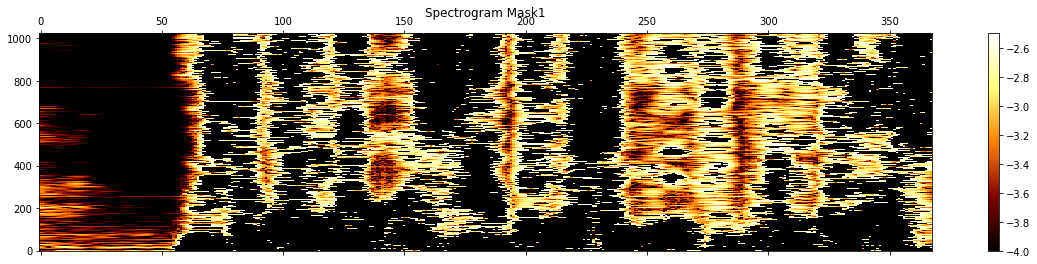

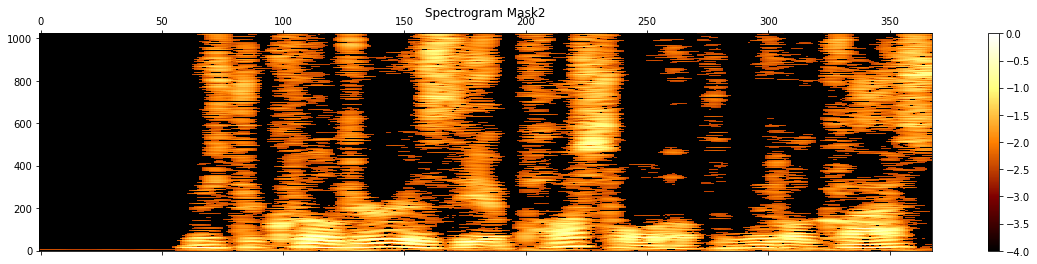

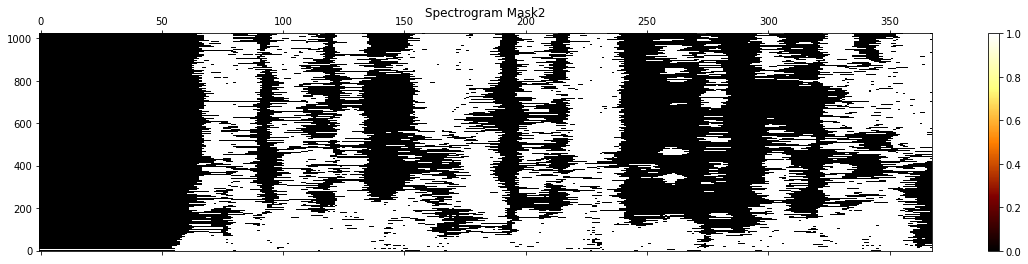

Have a glance of data:
 [ 0.00238037  0.0020752   0.00198364 ...  0.02346802 -0.00390625
  0.00369263]
Have a glance of stft:
 [[ 6.77432319e-02+0.00000000e+00j -1.86206558e-02+1.72019048e-02j
   1.65531208e-03+9.62899007e-03j ...  1.59246279e-03-7.31935806e-04j
  -2.41591698e-03-1.13711344e-04j -5.95352307e-04-1.84976471e-04j]
 [ 7.18216650e-02+0.00000000e+00j -2.80878916e-02+1.94912826e-02j
  -1.47696801e-02+7.96081025e-04j ...  1.48825899e-04-1.24614398e-03j
  -1.78843761e-03+1.74756008e-03j -1.00725132e-03-8.02897451e-04j]
 [ 8.37769847e-02+0.00000000e+00j -3.07603851e-02+2.07332450e-02j
  -7.23030488e-03-1.48254566e-02j ... -5.04931270e-04-7.20690729e-04j
   9.48875313e-05+2.37136245e-03j -1.60070428e-03-1.07879771e-03j]
 ...
 [-6.00961100e-03+0.00000000e+00j -3.20208896e-02+3.22192536e-01j
   2.22057371e-01-2.96027191e-01j ...  2.04264821e-01-2.83258494e-01j
  -4.11669978e-01-3.60520299e-01j -2.61331559e-01+8.85452030e-01j]
 [ 3.15519187e-02+0.00000000e+00j -1.99292543e-01+2.2061

In [2]:
# iPython specific stuff
# %matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import soundfile as sf


def overlap(X, window_size, window_step):
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start: stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
                           compute_onesided=True))

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[specgram < -thresh] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh  # set anything less than the threshold as the threshold

    return specgram


### Parameters ###
fft_size = 2048  # window size for the FFT
step_size = int(fft_size / 16)  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)

# Grab your wav and filter it

data, rate = \
    sf.read('/home/william/Documents/code/Desk top12.10from_disk/flac_dataforcnn/10001.flac')
data = data[:16000 * 3]

# mywav = '/home/william/Documents/code/Desk top12.10from_disk/flac_dataforcnn/10001.flac'
# rate, data = wavfile.read(mywav)
# data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0] / float(rate) > 10:
    data = data[0:rate * 10]
print('Length in time (s): ', np.shape(data)[0] / float(rate))

wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size=fft_size,
                                     step_size=step_size, log=True, thresh=spec_thresh)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot,
                 origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')
plt.show()

wav_spectrogram_mask1 = np.where(wav_spectrogram < -2.5, wav_spectrogram, -4)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(wav_spectrogram_mask1), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot,
                 origin='lower')
fig.colorbar(cax)
plt.title('Spectrogram Mask1')
plt.show()

wav_spectrogram_mask2 = np.where(wav_spectrogram > -2.5, wav_spectrogram, -4)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(wav_spectrogram_mask2), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot,
                 origin='lower')
fig.colorbar(cax)
plt.title('Spectrogram Mask2')
plt.show()

wav_spectrogram_mask3 = np.where(wav_spectrogram_mask2 != -4, wav_spectrogram_mask2, 0
                                 )

wav_spectrogram_mask4 = np.where(wav_spectrogram_mask3 == 0, wav_spectrogram_mask3, 1
                                 )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(wav_spectrogram_mask4), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot,
                 origin='lower')
fig.colorbar(cax)
plt.title('Spectrogram Mask2')
plt.show()

print('Have a glance of data:\n', data)

stft_complex_value = stft(data, fftsize=fft_size, step=step_size, real=False,
                           compute_onesided=True)

print('Have a glance of stft:\n', stft_complex_value)




